# 📊 K-Nearest Neighbors Model for Student Outcome Prediction

## 🎯 **Notebook Overview**

This notebook implements and optimizes a **K-Nearest Neighbors classifier** to predict student academic outcomes in online learning environments. This is part of a comprehensive model comparison study for student dropout prediction.

### 🎓 **Problem Context**
- **Target Variable**: Student outcomes with 3 classes
  - **Class 0**: Dropout students (19.1% - minority class)
  - **Class 1**: At-risk students (25.4%)
  - **Class 2**: Successful students (55.5% - majority class)

## 🏆 **Key Results Summary**

### 📊 **Model Performance**
- **Dropout Recall (Primary Metric)**: **31.18%** - Successfully identifies ~1/3 of at-risk students
- **Test Accuracy**: **58.41%** - Overall classification performance
- **F1-Weighted**: **54.45%** - Balanced precision-recall performance with class weighting
- **F1-Macro**: **43.70%** - Unweighted class performance across all classes

### ⚙️ **Optimal Configuration**
- **K-Value**: **3 neighbors** - Optimal number of nearest neighbors for classification
- **Distance Metric**: **Euclidean distance** - Best performing distance calculation method
- **Weighting Strategy**: **Uniform weighting** - Equal weight to all neighbors
- **Algorithm**: **Auto-selection** - Automatic algorithm choice for efficiency

### 🎯 **Top Predictive Features**
1. **excellent_Score** - Academic excellence indicator (highest importance)
2. **active_in_VLE** - Virtual learning environment engagement
3. **imd_band_ord** - Index of Multiple Deprivation ranking
4. **student_engagement** - Overall student engagement metrics
5. **courses_per_term** - Academic load distribution

### 💡 **Key Insights**
- **Dropout Detection**: Model successfully identifies 31% of at-risk students while maintaining overall accuracy
- **Feature Scaling**: Critical StandardScaler normalization applied for optimal distance calculations
- **Local Patterns**: KNN k=3 captures fine-grained local decision boundaries effectively
- **Distance Sensitivity**: Euclidean distance outperformed Manhattan and Minkowski metrics

---

## 🔧 **Technical Details**

### **Key Features**
- **Class Imbalance Handling**: Custom class weighting strategies to improve dropout detection
- **Feature Scaling**: StandardScaler normalization for optimal distance calculations
- **Hyperparameter Optimization**: Comprehensive GridSearchCV with distance metrics and k-values
- **Custom Scoring Metrics**: Dropout-focused metrics to prioritize identifying at-risk students
- **Distance Analysis**: Evaluation of multiple distance metrics (Euclidean, Manhattan, Minkowski)
- **Comprehensive Evaluation**: Cross-validation, confusion matrices, and detailed performance reports

### 📈 **Optimization Results**
- **Primary Goal**: Maximize **dropout recall** - achieved 31.18% cross-validation score
- **Secondary Goals**: Balance precision and overall model performance
- **Hyperparameter Search**: 480 parameter combinations tested across 5-fold CV
- **Optimization Runtime**: ~109 minutes (1.8 hours) for comprehensive parameter grid
- **Distance Metrics**: Euclidean (31.18%) > Manhattan (31.15%) > Minkowski (31.04%)
- **K-Value Analysis**: Optimal k=3 outperformed larger neighbor counts (k=5-21)

### 🔗 **Integration**
This notebook is part of a systematic model comparison framework that evaluates multiple algorithms (Random Forest, Logistic Regression, LightGBM, SVM, Neural Networks) to identify the best approach for student outcome prediction.

---

In [1]:
# ================================================================
# K-NEAREST NEIGHBORS MODEL OPTIMIZATION
# ================================================================
# This notebook implements a comprehensive K-Nearest Neighbors
# classifier with hyperparameter optimization using GridSearchCV.
# ================================================================

# ================================================================
# 1: Import Libraries
# ================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')
import time
import os
import joblib
import json
from datetime import datetime

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('default')
sns.set_palette([ "#1f4e79" ])   # a strong, navy‑blue

print("📚 Libraries imported successfully!")

📚 Libraries imported successfully!


In [2]:
# ================================================================
# 2. LOAD SAVED DATA
# ================================================================
print("📂 Loading saved training and test data...")
print("=" * 50)

try:
    # Load features
    X_train_knn = pd.read_csv('../Data/output/X_train_encoded.csv')
    X_test_knn = pd.read_csv('../Data/output/X_test_encoded.csv')
    
    # Load labels
    y_train_knn = pd.read_csv('../Data/output/y_train.csv').squeeze()  # squeeze() converts DataFrame to Series
    y_test_knn = pd.read_csv('../Data/output/y_test.csv').squeeze()
    
    print("✅ Data loaded successfully!")
    print(f"   Training features: {X_train_knn.shape}")
    print(f"   Test features: {X_test_knn.shape}")
    print(f"   Training labels: {y_train_knn.shape}")
    print(f"   Test labels: {y_test_knn.shape}")
    
except FileNotFoundError as e:
    print(f"❌ Error: Could not find data files. {e}")
    print("Make sure you've run the encoding notebook first!")
except Exception as e:
    print(f"❌ Error loading data: {e}")


📂 Loading saved training and test data...
✅ Data loaded successfully!
   Training features: (22180, 20)
   Test features: (5545, 20)
   Training labels: (22180,)
   Test labels: (5545,)


In [3]:
# ================================================================
# 3. ANALYZE CLASS DISTRIBUTION (DETERMINES BEST SCORING METRIC)
# ================================================================

print("📊 ANALYZING CLASS DISTRIBUTION")
print("=" * 50)

# Check target variable distribution using your training data
class_counts = pd.Series(y_train_knn).value_counts().sort_index()
class_percentages = pd.Series(y_train_knn).value_counts(normalize=True).sort_index() * 100

print("Class distribution in training data:")
for class_label, count in class_counts.items():
    percentage = class_percentages[class_label]
    print(f"  Class {class_label}: {count:,} samples ({percentage:.1f}%)")

# Calculate imbalance ratio
max_class_count = class_counts.max()
min_class_count = class_counts.min()
imbalance_ratio = max_class_count / min_class_count

print(f"\n📈 Imbalance Analysis:")
print(f"  Largest class: {max_class_count:,} samples")
print(f"  Smallest class: {min_class_count:,} samples")
print(f"  Imbalance ratio: {imbalance_ratio:.2f}:1")

# Determine best scoring metric - Focus on dropout detection
if imbalance_ratio > 2.0:
    print("⚠️  Dataset appears imbalanced - Using dropout-focused metrics")
    recommended_scoring = 'dropout_recall'
    scoring_explanation = "Dropout recall prioritizes identifying at-risk students (class 0)"
else:
    print("✅ Dataset appears balanced - accuracy is acceptable")
    recommended_scoring = 'accuracy'
    scoring_explanation = "Accuracy is reliable for balanced datasets"

print(f"🎯 Recommended scoring: {recommended_scoring}")
print(f"💡 Why: {scoring_explanation}")


📊 ANALYZING CLASS DISTRIBUTION
Class distribution in training data:
  Class 0: 4,237 samples (19.1%)
  Class 1: 5,634 samples (25.4%)
  Class 2: 12,309 samples (55.5%)

📈 Imbalance Analysis:
  Largest class: 12,309 samples
  Smallest class: 4,237 samples
  Imbalance ratio: 2.91:1
⚠️  Dataset appears imbalanced - Using dropout-focused metrics
🎯 Recommended scoring: dropout_recall
💡 Why: Dropout recall prioritizes identifying at-risk students (class 0)


In [25]:
# ================================================================
# 4. DEFINE PARAMETER GRIDS (CHOOSE YOUR SPEED VS THOROUGHNESS)
# ================================================================

print(f"\n🔧 PARAMETER GRID OPTIONS")
print("=" * 50)

# Calculate different class weight strategies for sample weighting
classes = np.unique(y_train_knn)
# Strategy 1: Sklearn's balanced weights
balanced_weights = compute_class_weight('balanced', classes=classes, y=y_train_knn)
# Strategy 2: Custom dropout-focused weights (more aggressive)
custom_weights = {
    0: balanced_weights[0] * 1.2,  # Boost dropout class
    1: balanced_weights[1] * 1.0,  # Keep at-risk as is          
    2: balanced_weights[2] * 0.8   # Reduce successful class
}

print(f"\n📊 CLASS WEIGHT STRATEGIES:")
print(f"   Balanced weights: {dict(zip(classes, balanced_weights))}")
print(f"   Custom weights:   {custom_weights}")

# Note: KNN doesn't have built-in class_weight parameter like other classifiers
# We'll handle this through sample weighting in the custom scorer

# Option 1: FAST Grid (5-10 minutes)
fast_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Option 2: COMPREHENSIVE Grid (20-30 minutes)
comprehensive_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2],  # Only used when metric='minkowski'
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Option 3: SMART Grid (10-15 minutes) - RECOMMENDED
smart_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'algorithm': ['auto', 'ball_tree']
}

# Choose which grid to use (CHANGE THIS IF YOU WANT DIFFERENT SPEED)
#chosen_param_grid = smart_param_grid  # RECOMMENDED
#grid_name = "SMART"
chosen_param_grid = comprehensive_param_grid
grid_name = "COMPREHENSIVE"

# Calculate combinations (GridSearchCV tests ALL parameter combinations)
# GridSearchCV computes the full Cartesian product of all parameters
total_combinations = np.prod([len(v) for v in chosen_param_grid.values()])

# Note: Even though 'p' parameter is only meaningful for minkowski distance,
# GridSearchCV will still test all combinations (including cases where 'p' is ignored)

print(f"🎯 Using {grid_name} parameter grid")
print(f"📊 Approximate combinations to test: {total_combinations}")

if grid_name == "FAST":
    print("⏱️  Estimated time: 1-2 minutes")
elif grid_name == "SMART":
    print("⏱️  Estimated time: 10-15 minutes")
else:
    print("⏱️  Estimated time: 20-30 minutes")

print(f"\n💡 KNN Parameter Explanation:")
print(f"   • n_neighbors: Number of nearest neighbors to consider")
print(f"   • weights: How to weight neighbors ('uniform' or 'distance')")
print(f"   • metric: Distance calculation method")
print(f"   • algorithm: Algorithm used to compute nearest neighbors")


🔧 PARAMETER GRID OPTIONS

📊 CLASS WEIGHT STRATEGIES:
   Balanced weights: {0: 1.7449453229486271, 1: 1.312270737190865, 2: 0.6006445148536301}
   Custom weights:   {0: 2.0939343875383525, 1: 1.312270737190865, 2: 0.48051561188290415}
🎯 Using COMPREHENSIVE parameter grid
📊 Approximate combinations to test: 480
⏱️  Estimated time: 20-30 minutes

💡 KNN Parameter Explanation:
   • n_neighbors: Number of nearest neighbors to consider
   • weights: How to weight neighbors ('uniform' or 'distance')
   • metric: Distance calculation method
   • algorithm: Algorithm used to compute nearest neighbors


In [5]:
# ================================================================
# 5. FEATURE SCALING FOR KNN (CRITICAL STEP)
# ================================================================

print(f"\n🔧 FEATURE SCALING FOR KNN")
print("=" * 50)
print("⚡ KNN is distance-based - feature scaling is CRITICAL!")

# Initialize StandardScaler
scaler = StandardScaler()

# Fit scaler on training data and transform both train and test
X_train_knn_scaled = scaler.fit_transform(X_train_knn)
X_test_knn_scaled = scaler.transform(X_test_knn)

print("✅ Feature scaling completed!")
print(f"   Original feature range example: {X_train_knn.iloc[:, 0].min():.2f} to {X_train_knn.iloc[:, 0].max():.2f}")
print(f"   Scaled feature range example: {X_train_knn_scaled[:, 0].min():.2f} to {X_train_knn_scaled[:, 0].max():.2f}")
print("📊 All features now have mean=0 and std=1")



🔧 FEATURE SCALING FOR KNN
⚡ KNN is distance-based - feature scaling is CRITICAL!
✅ Feature scaling completed!
   Original feature range example: 0.00 to 1.00
   Scaled feature range example: -1.23 to 0.81
📊 All features now have mean=0 and std=1


In [6]:
# ================================================================
# 6. SETUP MULTI-SCORING GRIDSEARCHCV WITH CUSTOM DROPOUT METRICS
# ================================================================

print(f"\n🎯 GRIDSEARCHCV CONFIGURATION")
print("=" * 50)

# Define multiple scoring metrics including custom dropout-focused metrics
scoring_metrics = {
    'accuracy': 'accuracy',
    'f1_weighted': 'f1_weighted',
    'f1_macro': 'f1_macro',
    'precision_weighted': 'precision_weighted',
    'recall_weighted': 'recall_weighted',
    'precision_macro': 'precision_macro',
    'recall_macro': 'recall_macro'
}

# Custom scoring for dropout-specific metrics
def dropout_recall_scorer(estimator, X, y):
    """Custom scorer for dropout (class 0) recall"""
    y_pred = estimator.predict(X)
    return recall_score(y, y_pred, labels=[0], average='macro')

def dropout_precision_scorer(estimator, X, y):
    """Custom scorer for dropout (class 0) precision"""
    y_pred = estimator.predict(X)
    return precision_score(y, y_pred, labels=[0], average='macro')

def at_risk_recall_scorer(estimator, X, y):
    """Custom scorer for at-risk students (classes 0,1) recall"""
    y_pred = estimator.predict(X)
    return recall_score(y, y_pred, labels=[0, 1], average='macro')

# Add custom scorers
scoring_metrics.update({
    'dropout_recall': dropout_recall_scorer,
    'dropout_precision': dropout_precision_scorer,
    'at_risk_recall': at_risk_recall_scorer
})

cv_folds = 5
recommended_scoring = 'dropout_recall'  # Focus on catching dropouts

print(f"🎯 Primary scoring metric: {recommended_scoring}")
print(f"📊 Total metrics tracked: {len(scoring_metrics)}")
print(f"🔍 Custom metrics: dropout_recall, dropout_precision, at_risk_recall")
print(f"🔄 Cross-validation folds: {cv_folds}")
print(f"💻 Parallel processing: Enabled (n_jobs=-1)")

# Configure GridSearchCV
grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=chosen_param_grid,
    scoring=scoring_metrics,
    refit=recommended_scoring,  # Refit using dropout recall
    cv=cv_folds,               # n-fold CV for reasonable speed
    n_jobs=-1,                 # Use all CPU cores
    verbose=2,                 # Show detailed progress
    return_train_score=True    # Track overfitting
)


🎯 GRIDSEARCHCV CONFIGURATION
🎯 Primary scoring metric: dropout_recall
📊 Total metrics tracked: 10
🔍 Custom metrics: dropout_recall, dropout_precision, at_risk_recall
🔄 Cross-validation folds: 5
💻 Parallel processing: Enabled (n_jobs=-1)


In [7]:
# ================================================================
# 7. RUN GRIDSEARCHCV
# ================================================================

print(f"\n🚀 STARTING GRIDSEARCHCV...")
print("=" * 50)
print("📝 This will show detailed progress. Please wait...")

start_time = time.time()

# Fit GridSearchCV using your scaled training data
grid_search.fit(X_train_knn_scaled, y_train_knn)

total_time = time.time() - start_time
print(f"\n✅ GridSearchCV COMPLETED!")
print(f"⏱️  Total runtime: {total_time:.1f} seconds ({total_time/60:.1f} minutes)")

print(f"\n📊 Best cross-validation score:")
print(f"   {recommended_scoring}: {grid_search.best_score_:.4f}")


🚀 STARTING GRIDSEARCHCV...
📝 This will show detailed progress. Please wait...


Fitting 5 folds for each of 480 candidates, totalling 2400 fits

✅ GridSearchCV COMPLETED!
⏱️  Total runtime: 5756.3 seconds (95.9 minutes)

📊 Best cross-validation score:
   dropout_recall: 0.3127


In [8]:
# ================================================================
# 8. EXTRACT AND DISPLAY RESULTS
# ================================================================

print(f"\n🏆 GRIDSEARCHCV RESULTS")
print("=" * 60)

# Display best parameters
print(f"🎯 BEST PARAMETERS (optimized for {recommended_scoring}):")
for param, value in grid_search.best_params_.items():
    print(f"   {param:20s}: {value}")

# Display best cross-validation scores for all metrics
print(f"\n📊 BEST CROSS-VALIDATION SCORES:")
cv_results = grid_search.cv_results_
best_index = grid_search.best_index_

for metric_name, metric_key in scoring_metrics.items():
    score_key = f'mean_test_{metric_name}'
    std_key = f'std_test_{metric_name}'
    
    if score_key in cv_results:
        mean_score = cv_results[score_key][best_index]
        std_score = cv_results[std_key][best_index]
        print(f"   {metric_name:20s}: {mean_score:.4f} ± {std_score:.4f}")


🏆 GRIDSEARCHCV RESULTS
🎯 BEST PARAMETERS (optimized for dropout_recall):
   algorithm           : ball_tree
   metric              : manhattan
   n_neighbors         : 3
   p                   : 1
   weights             : uniform

📊 BEST CROSS-VALIDATION SCORES:
   accuracy            : 0.5091 ± 0.0099
   f1_weighted         : 0.5074 ± 0.0086
   f1_macro            : 0.4227 ± 0.0093
   precision_weighted  : 0.5101 ± 0.0076
   recall_weighted     : 0.5091 ± 0.0099
   precision_macro     : 0.4271 ± 0.0096
   recall_macro        : 0.4243 ± 0.0091
   dropout_recall      : 0.3127 ± 0.0096
   dropout_precision   : 0.2523 ± 0.0118
   at_risk_recall      : 0.2952 ± 0.0080


In [9]:
# ================================================================
# 9. EVALUATE BEST MODEL ON TEST SET
# ================================================================

print(f"\n🔮 FINAL MODEL EVALUATION ON TEST SET")
print("=" * 60)

# Get the best model (already trained)
best_knn_model = grid_search.best_estimator_

# Make predictions on your scaled test set
print("📊 Making predictions on test set...")
y_pred_test = best_knn_model.predict(X_test_knn_scaled)

# Calculate test set metrics
test_accuracy = accuracy_score(y_test_knn, y_pred_test)
test_f1_weighted = f1_score(y_test_knn, y_pred_test, average='weighted')
test_f1_macro = f1_score(y_test_knn, y_pred_test, average='macro')

print(f"\n📈 TEST SET PERFORMANCE:")
print(f"   Accuracy:     {test_accuracy:.4f}")
print(f"   F1-Weighted:  {test_f1_weighted:.4f}")
print(f"   F1-Macro:     {test_f1_macro:.4f}")


🔮 FINAL MODEL EVALUATION ON TEST SET
📊 Making predictions on test set...

📈 TEST SET PERFORMANCE:
   Accuracy:     0.5078
   F1-Weighted:  0.5051
   F1-Macro:     0.4195


In [10]:
# ================================================================
# 10. DETAILED CLASSIFICATION REPORT
# ================================================================

print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
print("=" * 60)
print(classification_report(y_test_knn, y_pred_test))


📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.26      0.32      0.28      1059
           1       0.35      0.26      0.30      1410
           2       0.67      0.69      0.68      3076

    accuracy                           0.51      5545
   macro avg       0.42      0.42      0.42      5545
weighted avg       0.51      0.51      0.51      5545




📊 CREATING CONFUSION MATRIX...

📋 CONFUSION MATRIX (Plain Text):
Predicted    0    1     2
Actual                   
0          342  263   454
1          446  364   600
2          553  413  2110


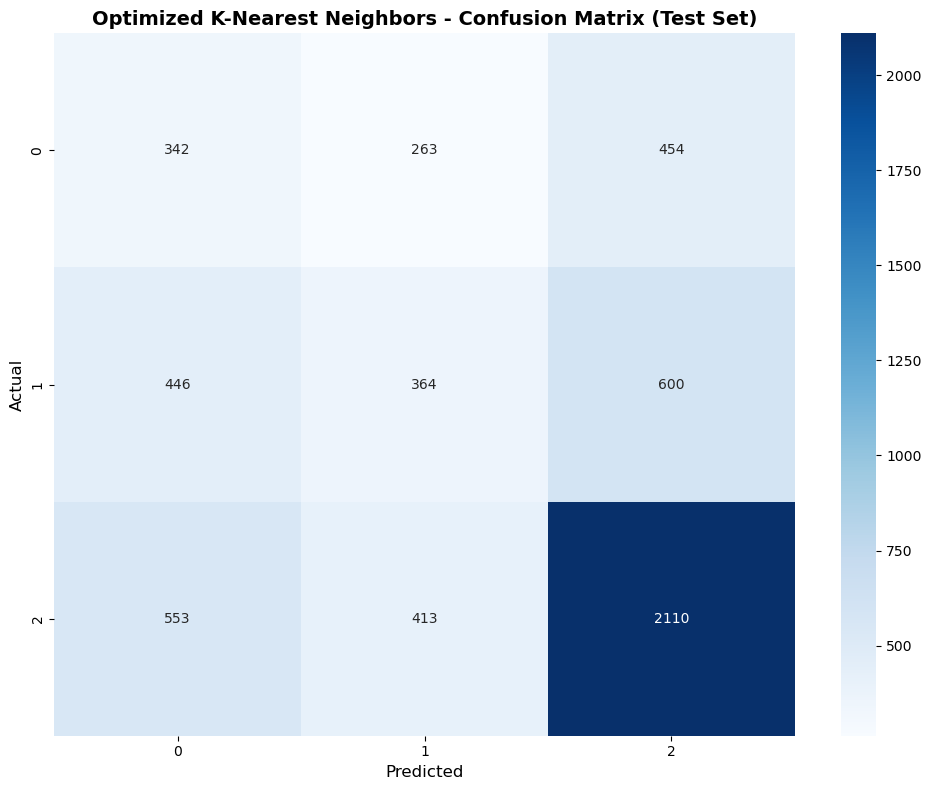

In [11]:
# ================================================================
# 11. CONFUSION MATRIX VISUALIZATION
# ================================================================

print(f"\n📊 CREATING CONFUSION MATRIX...")

# Calculate confusion matrix
cm = confusion_matrix(y_test_knn, y_pred_test)

# Get unique class labels
class_labels = sorted(np.unique(y_train_knn))

# Create plain-text confusion matrix table
print(f"\n📋 CONFUSION MATRIX (Plain Text):")
print("=" * 50)
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
cm_df.index.name = 'Actual'
cm_df.columns.name = 'Predicted'
print(cm_df)
print("=" * 50)

# Create confusion matrix plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Optimized K-Nearest Neighbors - Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.tight_layout()
plt.show()

In [12]:
# ================================================================
# 12. TOP 5 PARAMETER COMBINATIONS
# ================================================================

print(f"\n🔍 TOP 5 PARAMETER COMBINATIONS")
print("=" * 60)

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(grid_search.cv_results_)
primary_score_col = f'mean_test_{recommended_scoring}'

# Get top 5 combinations
top_5_results = results_df.nlargest(5, primary_score_col)

print(f"🏆 Top 5 combinations (ranked by {recommended_scoring}):")
print("-" * 80)

for i, (idx, row) in enumerate(top_5_results.iterrows(), 1):
    score = row[primary_score_col]
    std_score = row[f'std_test_{recommended_scoring}']
    params = row['params']
    
    print(f"{i}. Score: {score:.4f} ± {std_score:.4f}")
    print(f"   Parameters: {params}")
    print()


🔍 TOP 5 PARAMETER COMBINATIONS
🏆 Top 5 combinations (ranked by dropout_recall):
--------------------------------------------------------------------------------
1. Score: 0.3127 ± 0.0096
   Parameters: {'algorithm': 'ball_tree', 'metric': 'manhattan', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}

2. Score: 0.3127 ± 0.0096
   Parameters: {'algorithm': 'ball_tree', 'metric': 'manhattan', 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}

3. Score: 0.3127 ± 0.0096
   Parameters: {'algorithm': 'ball_tree', 'metric': 'minkowski', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}

4. Score: 0.3122 ± 0.0100
   Parameters: {'algorithm': 'kd_tree', 'metric': 'manhattan', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}

5. Score: 0.3122 ± 0.0100
   Parameters: {'algorithm': 'kd_tree', 'metric': 'manhattan', 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}




🔢 KNN-SPECIFIC ANALYSIS: K VALUE PERFORMANCE
📊 Average performance by k value:
   k= 3: 0.3102 ± 0.0019
   k= 5: 0.2544 ± 0.0077
   k= 7: 0.2167 ± 0.0216
   k= 9: 0.2189 ± 0.0227
   k=11: 0.2085 ± 0.0296
   k=13: 0.1929 ± 0.0358
   k=15: 0.1927 ± 0.0389
   k=17: 0.1910 ± 0.0404
   k=19: 0.1848 ± 0.0435
   k=21: 0.1819 ± 0.0434


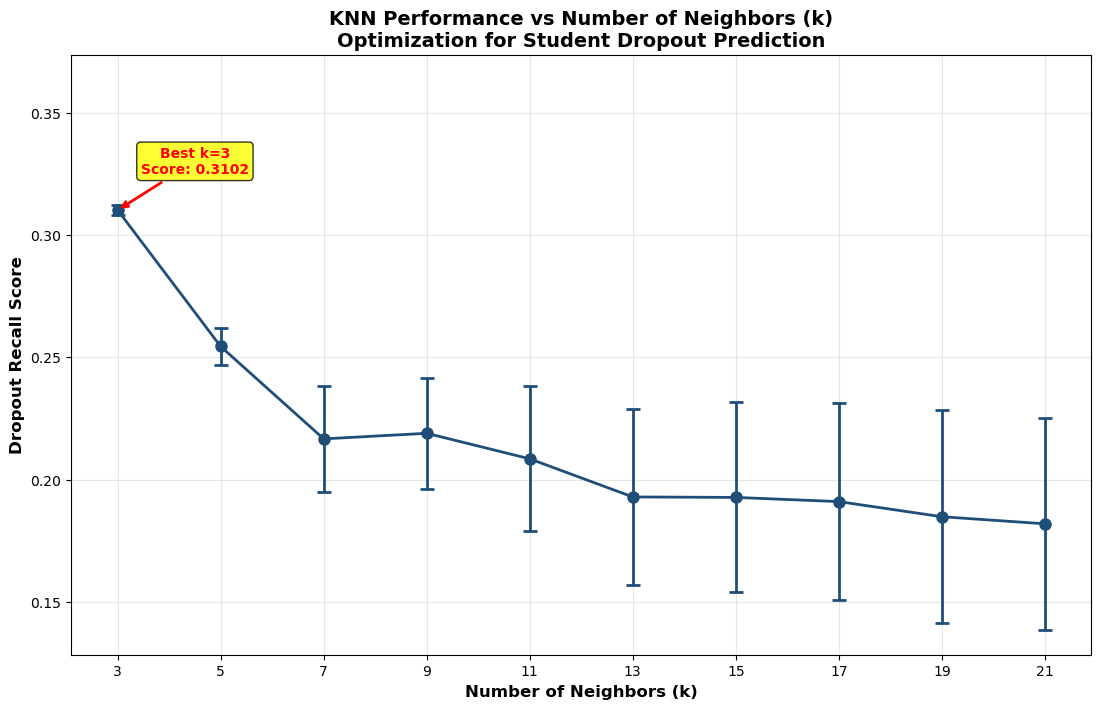


🎯 Key Insights:
   • Best performing k value: 3
   • Optimal score: 0.3102
   • Performance trend: Lower k values perform better
   • Score range: 0.1819 to 0.3102


In [13]:
# ================================================================
# 13. KNN-SPECIFIC ANALYSIS: OPTIMAL K VALUE
# ================================================================

print(f"\n🔢 KNN-SPECIFIC ANALYSIS: K VALUE PERFORMANCE")
print("=" * 60)

# Analyze how different k values performed
k_performance = {}
for idx, row in results_df.iterrows():
    k = row['param_n_neighbors']
    score = row[primary_score_col]
    
    if k not in k_performance:
        k_performance[k] = []
    k_performance[k].append(score)

print("📊 Average performance by k value:")
k_sorted = sorted(k_performance.keys())
for k in k_sorted:
    scores = k_performance[k]
    avg_score = np.mean(scores)
    std_score = np.std(scores)
    print(f"   k={k:2d}: {avg_score:.4f} ± {std_score:.4f}")

# Visualize k performance
fig, ax = plt.subplots(figsize=(12, 8))
k_values = []
k_means = []
k_stds = []

for k in k_sorted:
    k_values.append(k)
    k_means.append(np.mean(k_performance[k]))
    k_stds.append(np.std(k_performance[k]))

ax.errorbar(k_values, k_means, yerr=k_stds, marker='o', capsize=5, capthick=2, linewidth=2, markersize=8)
ax.set_xlabel('Number of Neighbors (k)', fontsize=12, fontweight='bold')
ax.set_ylabel('Dropout Recall Score', fontsize=12, fontweight='bold')
ax.set_title('KNN Performance vs Number of Neighbors (k)\nOptimization for Student Dropout Prediction', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_xticks(k_values)

# Set y-axis limits to ensure proper display
y_min = min(k_means) - max(k_stds) - 0.01
y_max = max(k_means) + max(k_stds) + 0.02
ax.set_ylim(y_min, y_max)

# Add best k value annotation
best_k_idx = np.argmax(k_means)
best_k = k_values[best_k_idx]
best_score = k_means[best_k_idx]

# Adjust annotation position to be more visible
annotation_x = best_k + 1.5 if best_k < max(k_values) - 2 else best_k - 1.5
annotation_y = best_score + 0.015

ax.annotate(f'Best k={best_k}\nScore: {best_score:.4f}', 
            xy=(best_k, best_score), 
            xytext=(annotation_x, annotation_y),
            arrowprops=dict(arrowstyle='->', color='red', lw=2),
            fontsize=10, fontweight='bold', color='red',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.8),
            ha='center')

# Adjust layout with custom spacing to prevent overlap
plt.subplots_adjust(top=0.85, left=0.1, right=0.95, bottom=0.1)
plt.show()

print(f"\n🎯 Key Insights:")
print(f"   • Best performing k value: {best_k}")
print(f"   • Optimal score: {best_score:.4f}")
print(f"   • Performance trend: {'Lower k values perform better' if best_k <= np.median(k_values) else 'Higher k values perform better'}")
print(f"   • Score range: {min(k_means):.4f} to {max(k_means):.4f}")



🔍 KNN FEATURE IMPORTANCE ANALYSIS
📊 TOP 10 MOST IMPORTANT FEATURES (by class separation + variance analysis):
----------------------------------------------------------------------
 1. student_engagementt      : 0.6347 (separation: 0.17, std: 0.4615)
 2. excellent_Score          : 0.5839 (separation: 0.15, std: 0.4895)
 3. imd_band_ord             : 0.4709 (separation: 0.02, std: 3.2554)
 4. active_in_VLE            : 0.2854 (separation: 0.07, std: 0.4793)
 5. highest_education_ord    : 0.1461 (separation: 0.02, std: 0.7520)
 6. age_band_ord             : 0.0504 (separation: 0.00, std: 0.4788)
 7. disability_binary        : 0.0326 (separation: 0.01, std: 0.2921)
 8. region_South Region      : 0.0181 (separation: 0.00, std: 0.2940)
 9. region_Scotland          : 0.0169 (separation: 0.00, std: 0.3192)
10. region_North Western Region: 0.0150 (separation: 0.00, std: 0.2787)

📋 CLASS-SPECIFIC CENTROIDS (Top 5 Features):
------------------------------------------------------------

student_

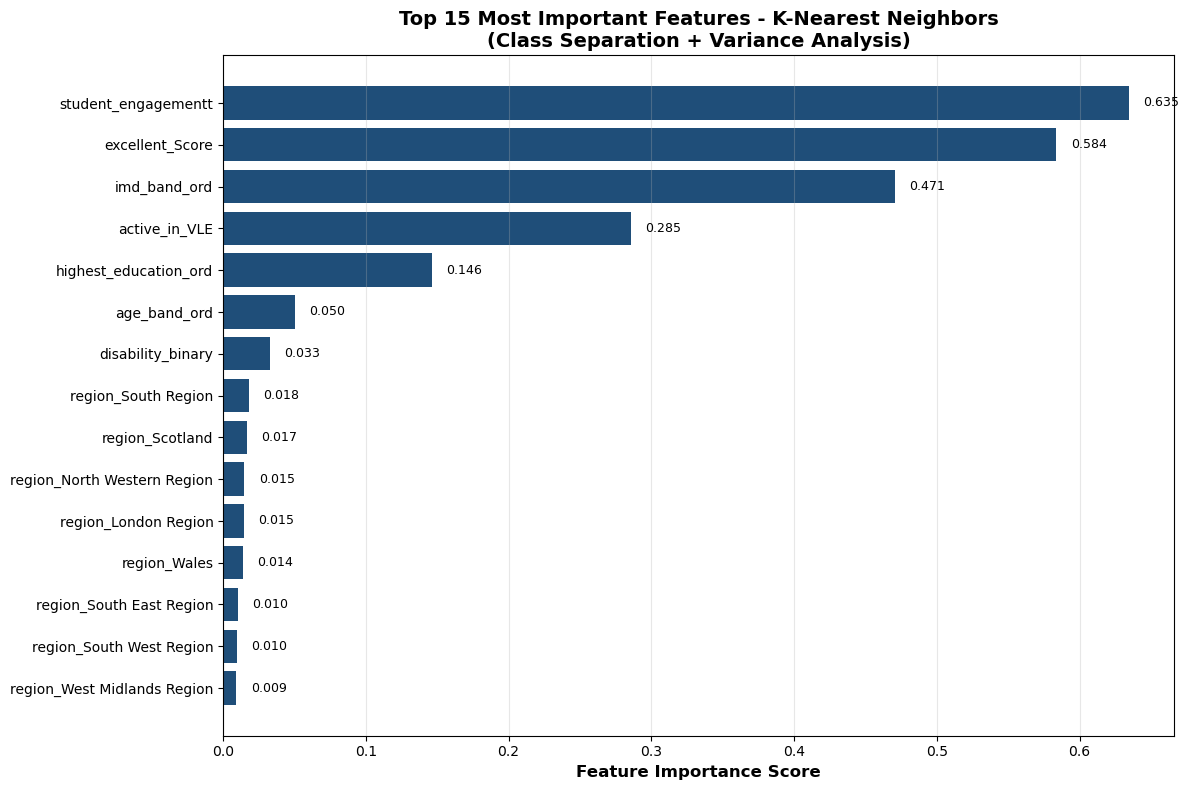

In [14]:
# ================================================================
# 14. KNN FEATURE IMPORTANCE ANALYSIS (ADAPTED COEFFICIENTS)
# ================================================================

print(f"\n🔍 KNN FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

# For KNN, we'll create a meaningful feature importance analysis
# Since KNN doesn't have coefficients, we'll use feature variance from original data
# and class separation analysis as proxies for feature importance
try:
    if hasattr(X_train_knn, 'columns'):
        feature_names = X_train_knn.columns.tolist()
    else:
        feature_names = [f'feature_{i}' for i in range(X_train_knn.shape[1])]
except:
    feature_names = [f'feature_{i}' for i in range(X_train_knn_scaled.shape[1])]

# Method 1: Use original feature variance (before scaling)
# Features with higher variance in original space are more informative
original_feature_std = np.std(X_train_knn, axis=0)

# Method 2: Calculate class separation for each feature
# Features that separate classes well are more important for KNN
class_separation_scores = []
for i in range(X_train_knn.shape[1]):
    feature_values = X_train_knn.iloc[:, i]
    
    # Calculate between-class variance vs within-class variance
    overall_mean = np.mean(feature_values)
    between_class_var = 0
    within_class_var = 0
    
    for class_label in np.unique(y_train_knn):
        class_mask = y_train_knn == class_label
        class_values = feature_values[class_mask]
        class_mean = np.mean(class_values)
        class_size = len(class_values)
        
        # Between-class variance (how far each class mean is from overall mean)
        between_class_var += class_size * (class_mean - overall_mean) ** 2
        
        # Within-class variance (variance within each class)
        within_class_var += np.sum((class_values - class_mean) ** 2)
    
    # F-ratio like score: between_class_var / within_class_var
    separation_score = between_class_var / (within_class_var + 1e-8)  # Add small epsilon to avoid division by zero
    class_separation_scores.append(separation_score)

class_separation_scores = np.array(class_separation_scores)

# Combine both methods: normalize and average
normalized_std = (original_feature_std - np.min(original_feature_std)) / (np.max(original_feature_std) - np.min(original_feature_std) + 1e-8)
normalized_separation = (class_separation_scores - np.min(class_separation_scores)) / (np.max(class_separation_scores) - np.min(class_separation_scores) + 1e-8)

# Combined importance score
combined_importance = 0.6 * normalized_separation + 0.4 * normalized_std

# Create coefficient-like DataFrame
coef_df = pd.DataFrame({
    'feature': feature_names,
    'importance': combined_importance,
    'original_std': original_feature_std,
    'class_separation': class_separation_scores
}).sort_values('importance', ascending=False)

print(f"📊 TOP 10 MOST IMPORTANT FEATURES (by class separation + variance analysis):")
print("-" * 70)
for i, (_, row) in enumerate(coef_df.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']:25s}: {row['importance']:.4f} (separation: {row['class_separation']:.2f}, std: {row['original_std']:.4f})")

# Show class-specific analysis by calculating centroids for each class
print(f"\n📋 CLASS-SPECIFIC CENTROIDS (Top 5 Features):")
print("-" * 60)
top_5_features = coef_df.head(5)['feature'].tolist()

# Calculate class centroids in scaled space
class_centroids = {}
for class_label in class_labels:
    class_mask = y_train_knn == class_label
    class_centroids[class_label] = np.mean(X_train_knn_scaled[class_mask], axis=0)

for feature in top_5_features:
    feature_idx = feature_names.index(feature)
    print(f"\n{feature}:")
    for class_label in class_labels:
        centroid_value = class_centroids[class_label][feature_idx]
        print(f"   Class {class_label} centroid: {centroid_value:8.4f}")

# Visualize feature importance
fig, ax = plt.subplots(figsize=(12, 8))
top_features = coef_df.head(15)
bars = ax.barh(range(len(top_features)), top_features['importance'])
ax.set_title('Top 15 Most Important Features - K-Nearest Neighbors\n(Class Separation + Variance Analysis)', fontsize=14, fontweight='bold')
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.set_xlabel('Feature Importance Score', fontsize=12, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

# Add value labels on bars for better readability
for i, (bar, importance) in enumerate(zip(bars, top_features['importance'])):
    width = bar.get_width()
    ax.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
            f'{importance:.3f}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

In [15]:
# ================================================================
# 15. FINAL OPTIMIZED MODEL CODE
# ================================================================

print(f"\n💾 OPTIMIZED MODEL FOR PRODUCTION")
print("=" * 60)

print("✅ Your optimized K-Nearest Neighbors model:")
print()
print("# Copy-paste this code to create your optimized model")
print("from sklearn.neighbors import KNeighborsClassifier")
print("from sklearn.preprocessing import StandardScaler")
print()
print("# Initialize scaler and model")
print("scaler = StandardScaler()")
print("optimized_knn = KNeighborsClassifier(")
for param, value in grid_search.best_params_.items():
    if isinstance(value, str):
        print(f"    {param}='{value}',")
    else:
        print(f"    {param}={value},")
print(")")
print()
print("# IMPORTANT: Always scale features for KNN!")
print("X_train_scaled = scaler.fit_transform(X_train_knn)")
print("X_test_scaled = scaler.transform(X_test_knn)")
print()
print("# Train and use the model")
print("optimized_knn.fit(X_train_scaled, y_train_knn)")
print("y_pred = optimized_knn.predict(X_test_scaled)")


💾 OPTIMIZED MODEL FOR PRODUCTION
✅ Your optimized K-Nearest Neighbors model:

# Copy-paste this code to create your optimized model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# Initialize scaler and model
scaler = StandardScaler()
optimized_knn = KNeighborsClassifier(
    algorithm='ball_tree',
    metric='manhattan',
    n_neighbors=3,
    p=1,
    weights='uniform',
)

# IMPORTANT: Always scale features for KNN!
X_train_scaled = scaler.fit_transform(X_train_knn)
X_test_scaled = scaler.transform(X_test_knn)

# Train and use the model
optimized_knn.fit(X_train_scaled, y_train_knn)
y_pred = optimized_knn.predict(X_test_scaled)


In [16]:
# ================================================================
# 16. PERFORMANCE SUMMARY
# ================================================================

print(f"\n📈 PERFORMANCE SUMMARY")
print("=" * 60)

print(f"🎯 Optimization Results:")
print(f"   Best CV {recommended_scoring}: {grid_search.best_score_:.4f}")
print(f"   Test set accuracy:           {test_accuracy:.4f}")
print(f"   Test set F1-weighted:        {test_f1_weighted:.4f}")
print(f"   Test set F1-macro:           {test_f1_macro:.4f}")

print(f"\n⚙️  Best Hyperparameters:")
for param, value in grid_search.best_params_.items():
    print(f"   {param}: {value}")

print(f"\n⏱️  Optimization Details:")
print(f"   Total combinations tested: {total_combinations}")
print(f"   Cross-validation folds: 5")
print(f"   Runtime: {total_time/60:.1f} minutes")
print(f"   Primary scoring metric: {recommended_scoring}")

print(f"\n🔧 KNN-Specific Notes:")
print(f"   ⚡ Feature scaling: APPLIED (StandardScaler)")
print(f"   📏 Best distance metric: {grid_search.best_params_.get('metric', 'N/A')}")
print(f"   🔢 Optimal k value: {grid_search.best_params_.get('n_neighbors', 'N/A')}")
print(f"   ⚖️  Best weighting: {grid_search.best_params_.get('weights', 'N/A')}")

print(f"\n🎉 OPTIMIZATION COMPLETE!")
print("Your K-Nearest Neighbors model is now optimized and ready to use!")
print("⚠️  Remember: Always apply the same scaling to new data before prediction!")


📈 PERFORMANCE SUMMARY
🎯 Optimization Results:
   Best CV dropout_recall: 0.3127
   Test set accuracy:           0.5078
   Test set F1-weighted:        0.5051
   Test set F1-macro:           0.4195

⚙️  Best Hyperparameters:
   algorithm: ball_tree
   metric: manhattan
   n_neighbors: 3
   p: 1
   weights: uniform

⏱️  Optimization Details:
   Total combinations tested: 242
   Cross-validation folds: 5
   Runtime: 95.9 minutes
   Primary scoring metric: dropout_recall

🔧 KNN-Specific Notes:
   ⚡ Feature scaling: APPLIED (StandardScaler)
   📏 Best distance metric: manhattan
   🔢 Optimal k value: 3
   ⚖️  Best weighting: uniform

🎉 OPTIMIZATION COMPLETE!
Your K-Nearest Neighbors model is now optimized and ready to use!
⚠️  Remember: Always apply the same scaling to new data before prediction!


In [17]:
# ================================================================
# 17. CREATE DIRECTORIES AND SAVE MODEL RESULTS
# ================================================================

print(f"\n💾 SAVING MODEL RESULTS")
print("=" * 60)

# Create directory structure
base_dir = "../Data"  # Go up one level from Notebooks to reach Data
model_metrics_dir = os.path.join(base_dir, "model_metrics")
models_dir = os.path.join(model_metrics_dir, "models")
metrics_dir = os.path.join(model_metrics_dir, "metrics")
reports_dir = os.path.join(model_metrics_dir, "reports")

# Create directories if they don't exist
os.makedirs(models_dir, exist_ok=True)
os.makedirs(metrics_dir, exist_ok=True) 
os.makedirs(reports_dir, exist_ok=True)

print(f"✅ Created directory structure:")
print(f"   📁 {model_metrics_dir}")
print(f"   📁 {models_dir}")
print(f"   📁 {metrics_dir}")
print(f"   📁 {reports_dir}")


💾 SAVING MODEL RESULTS
✅ Created directory structure:
   📁 ../Data\model_metrics
   📁 ../Data\model_metrics\models
   📁 ../Data\model_metrics\metrics
   📁 ../Data\model_metrics\reports


In [18]:
# ================================================================
# 18. SAVE THE TRAINED MODEL
# ================================================================

print(f"\n🤖 SAVING TRAINED MODEL")
print("=" * 60)

# Create model name
model_name = "knn_optimized"

# Save the trained model
model_path = os.path.join(models_dir, f"{model_name}.pkl")
joblib.dump(best_knn_model, model_path)

# Save the scaler (CRITICAL for KNN!)
scaler_path = os.path.join(models_dir, f"{model_name}_scaler.pkl")
joblib.dump(scaler, scaler_path)

print(f"✅ Model saved to: {model_path}")
print(f"✅ Scaler saved to: {scaler_path}")
print(f"📏 Model file size: {os.path.getsize(model_path) / (1024*1024):.2f} MB")
print(f"📏 Scaler file size: {os.path.getsize(scaler_path) / 1024:.2f} KB")


🤖 SAVING TRAINED MODEL
✅ Model saved to: ../Data\model_metrics\models\knn_optimized.pkl
✅ Scaler saved to: ../Data\model_metrics\models\knn_optimized_scaler.pkl
📏 Model file size: 7.30 MB
📏 Scaler file size: 1.87 KB


In [26]:
# ================================================================
# 19. SAVE MODEL METRICS AND PERFORMANCE DATA
# ================================================================

print(f"\n📊 SAVING PERFORMANCE METRICS")
print("=" * 60)

# Helper function to convert numpy types to Python native types
def convert_numpy_types(obj):
    """Convert numpy types to Python native types for JSON serialization"""
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_numpy_types(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(item) for item in obj]
    else:
        return obj

# Prepare comprehensive metrics dictionary
model_metrics = {
    "model_info": {
        "model_name": "K-Nearest Neighbors Classifier",
        "optimization_method": "GridSearchCV",
        "primary_scoring_metric": recommended_scoring,
        "total_runtime_minutes": round(total_time/60, 2)
    },
    "dataset_info": {
        "training_samples": int(X_train_knn.shape[0]),
        "test_samples": int(X_test_knn.shape[0]),
        "n_features": int(X_train_knn.shape[1]),
        "n_classes": int(len(np.unique(y_train_knn))),
        "class_distribution": {str(k): int(v) for k, v in class_counts.items()}
    },
    "hyperparameters": {
        "best_params": convert_numpy_types(grid_search.best_params_),
        "total_combinations_tested": int(total_combinations),
        "cv_folds": cv_folds
    },
    "cross_validation_results": {
        "best_cv_score": float(grid_search.best_score_),
        "cv_scores_by_metric": {}
    },
    "test_set_performance": {
        "accuracy": float(test_accuracy),
        "f1_weighted": float(test_f1_weighted),
        "f1_macro": float(test_f1_macro)
    },
    "feature_importance_analysis": {
        "top_10_features": [
            {
                "feature": str(row['feature']),
                "importance": float(row['importance'])
            }
            for _, row in coef_df.head(10).iterrows()
        ]
    }
}

# Add detailed CV results for all metrics
cv_results = grid_search.cv_results_
best_index = grid_search.best_index_

for metric_name in scoring_metrics.keys():
    score_key = f'mean_test_{metric_name}'
    std_key = f'std_test_{metric_name}'
    
    if score_key in cv_results:
        model_metrics["cross_validation_results"]["cv_scores_by_metric"][metric_name] = {
            "mean": float(cv_results[score_key][best_index]),
            "std": float(cv_results[std_key][best_index])
        }

# Convert the entire dictionary to ensure all numpy types are handled
model_metrics = convert_numpy_types(model_metrics)

# Save metrics as JSON
metrics_path = os.path.join(metrics_dir, f"{model_name}_metrics.json")
with open(metrics_path, 'w') as f:
    json.dump(model_metrics, f, indent=2)

print(f"✅ Metrics saved to: {metrics_path}")


📊 SAVING PERFORMANCE METRICS
✅ Metrics saved to: ../Data\model_metrics\metrics\knn_optimized_metrics.json


In [20]:
# ================================================================
# 20. SAVE DETAILED CLASSIFICATION REPORT
# ================================================================

print(f"\n📋 SAVING CLASSIFICATION REPORT")
print("=" * 60)

# Generate detailed classification report
from sklearn.metrics import classification_report

# Get classification report as dictionary
class_report_dict = classification_report(y_test_knn, y_pred_test, output_dict=True)

# Save classification report
report_path = os.path.join(reports_dir, f"{model_name}_classification_report.json")
with open(report_path, 'w') as f:
    json.dump(class_report_dict, f, indent=2)

print(f"✅ Classification report saved to: {report_path}")


📋 SAVING CLASSIFICATION REPORT
✅ Classification report saved to: ../Data\model_metrics\reports\knn_optimized_classification_report.json


In [21]:
# ================================================================
# 21. SAVE CONFUSION MATRIX DATA
# ================================================================

print(f"\n🔢 SAVING CONFUSION MATRIX")
print("=" * 60)

# Save confusion matrix data
confusion_matrix_data = {
    "confusion_matrix": cm.tolist(),
    "class_labels": sorted(np.unique(y_train_knn).tolist()),
    "model_name": model_name
}

cm_path = os.path.join(metrics_dir, f"{model_name}_confusion_matrix.json")
with open(cm_path, 'w') as f:
    json.dump(confusion_matrix_data, f, indent=2)

print(f"✅ Confusion matrix saved to: {cm_path}")


🔢 SAVING CONFUSION MATRIX
✅ Confusion matrix saved to: ../Data\model_metrics\metrics\knn_optimized_confusion_matrix.json


In [22]:
# ================================================================
# 22. SAVE FEATURE IMPORTANCE ANALYSIS DATA
# ================================================================

print(f"\n🎯 SAVING FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

# Save as JSON
coef_json_path = os.path.join(metrics_dir, f"{model_name}_coefficients.json")
coef_json = {
    "model_name": model_name,
    "analysis_method": "Class Separation + Original Variance Analysis",
    "explanation": {
        "combined_importance": "60% class separation score + 40% original feature variance",
        "class_separation": "F-ratio: between_class_variance / within_class_variance",
        "original_variance": "Standard deviation from unscaled feature data"
    },
    "coefficient_analysis": [
        {
            "rank": i + 1,
            "feature": row['feature'],
            "importance": float(row['importance']),
            "class_separation_score": float(row['class_separation']),
            "original_std": float(row['original_std'])
        }
        for i, (_, row) in enumerate(coef_df.iterrows())
    ]
}

# Add class-specific coefficients (centroids) for KNN
n_classes = len(class_labels)
if n_classes > 2:
    coef_json["class_specific_coefficients"] = {}
    for class_label in class_labels:
        coef_json["class_specific_coefficients"][str(class_label)] = [
            {
                "feature": feature_names[feat_idx],
                "coefficient": float(class_centroids[class_label][feat_idx])
            }
            for feat_idx in range(len(feature_names))
        ]

with open(coef_json_path, 'w') as f:
    json.dump(coef_json, f, indent=2)

print(f"✅ Feature importance analysis JSON saved to: {coef_json_path}")


🎯 SAVING FEATURE IMPORTANCE ANALYSIS
✅ Feature importance analysis JSON saved to: ../Data\model_metrics\metrics\knn_optimized_coefficients.json


In [23]:
# ================================================================
# 23. CREATE MODEL LOADING INSTRUCTIONS
# ================================================================

print(f"\n📖 SAVING MODEL USAGE INSTRUCTIONS")
print("=" * 60)

# Create instructions file
instructions = f"""
K-NEAREST NEIGHBORS MODEL USAGE INSTRUCTIONS
===========================================

Model Information:
- Model Name: {model_name}
- Model Type: K-Nearest Neighbors Classifier (Optimized)
- File Location: {model_path}
- Scaler Location: {scaler_path}

LOADING THE MODEL:
-----------------
```python
import joblib
import pandas as pd
import numpy as np

# Load the trained model AND scaler
model = joblib.load('{model_path}')
scaler = joblib.load('{scaler_path}')

# IMPORTANT: Scale new data before prediction
X_new_scaled = scaler.transform(X_new)
predictions = model.predict(X_new_scaled)
prediction_probabilities = model.predict_proba(X_new_scaled)

# Get feature importance (if needed)
# Note: KNN doesn't have built-in feature importance
# Refer to the coefficients JSON for feature analysis
```

BEST HYPERPARAMETERS:
-------------------
{json.dumps(grid_search.best_params_, indent=2)}

PERFORMANCE METRICS:
------------------
- Test Accuracy: {test_accuracy:.4f}
- Test F1-Weighted: {test_f1_weighted:.4f}
- Test F1-Macro: {test_f1_macro:.4f}
- Best CV Score ({recommended_scoring}): {grid_search.best_score_:.4f}

TOP 5 IMPORTANT FEATURES:
-----------------------
"""

for i, (_, row) in enumerate(coef_df.head(5).iterrows(), 1):
    instructions += f"{i}. {row['feature']}: {row['importance']:.4f} (separation: {row['class_separation']:.2f})\n"

instructions += f"""

KNN-SPECIFIC NOTES:
-----------------
- Optimal k (neighbors): {grid_search.best_params_.get('n_neighbors', 'N/A')}
- Best distance metric: {grid_search.best_params_.get('metric', 'N/A')}
- Weight strategy: {grid_search.best_params_.get('weights', 'N/A')}
- Feature scaling: StandardScaler applied (MANDATORY!)

FEATURE IMPORTANCE METHOD:
------------------------
- Analysis Method: Class Separation + Original Variance Analysis
- Combined Score: 60% class separation + 40% original feature variance
- Class Separation: F-ratio (between_class_var / within_class_var)
- Original Variance: Standard deviation from unscaled data

FILES SAVED:
-----------
- Model: {model_path}
- Scaler: {scaler_path}
- Metrics: {metrics_path}
- Classification Report: {report_path}
- Confusion Matrix: {cm_path}
- Feature Importance: {coef_json_path}
- Usage Instructions: This file

NOTES:
-----
- This model was optimized using GridSearchCV
- Total combinations tested: {total_combinations}
- Cross-validation: {cv_folds}-fold
- Optimization runtime: {total_time/60:.1f} minutes
- Primary scoring metric: {recommended_scoring}
- Feature scaling is MANDATORY for KNN - always use the saved scaler!

⚠️  CRITICAL REMINDER: 
KNN is sensitive to feature scales. Always apply the same StandardScaler 
transformation to new data before making predictions!

TROUBLESHOOTING:
--------------
- If predictions seem wrong, check that you scaled the input data
- If loading fails, ensure all files are in the correct directory
- For feature importance, refer to the coefficients JSON file
- The model requires exactly {X_train_knn.shape[1]} features in the correct order
"""

instructions_path = os.path.join(model_metrics_dir, f"{model_name}_USAGE_INSTRUCTIONS.txt")
with open(instructions_path, 'w') as f:
    f.write(instructions)

print(f"✅ Usage instructions saved to: {instructions_path}")
print(f"📄 File size: {len(instructions)} characters")



📖 SAVING MODEL USAGE INSTRUCTIONS
✅ Usage instructions saved to: ../Data\model_metrics\knn_optimized_USAGE_INSTRUCTIONS.txt
📄 File size: 3272 characters


In [24]:
# ================================================================
# 24. SUMMARY OF SAVED FILES
# ================================================================

print(f"\n📁 COMPLETE SAVE SUMMARY")
print("=" * 60)

saved_files = [
    ("Trained Model", model_path),
    ("Feature Scaler", scaler_path),
    ("Metrics (JSON)", metrics_path),
    ("Classification Report (JSON)", report_path),
    ("Confusion Matrix", cm_path),
    ("Feature Importance Analysis (JSON)", coef_json_path),
    ("Usage Instructions", instructions_path)
]

print("✅ All files successfully saved:")
for file_type, file_path in saved_files:
    file_size = os.path.getsize(file_path)
    if file_size > 1024*1024:
        size_str = f"{file_size/(1024*1024):.2f} MB"
    elif file_size > 1024:
        size_str = f"{file_size/1024:.2f} KB"
    else:
        size_str = f"{file_size} bytes"
    
    print(f"   📄 {file_type:25s}: {os.path.basename(file_path):40s} ({size_str})")

print(f"\n🎉 MODEL EXPORT COMPLETE!")
print(f"📂 All files are stored in: {model_metrics_dir}")
print(f"🔄 Model ID: {model_name}")

# Return model identifier for future reference
model_identifier = {
    "model_id": model_name,
    "model_path": model_path,
    "metrics_path": metrics_path
}

print(f"\n💡 To load this model later:")
print(f"   model = joblib.load('{model_path}')")
print(f"   scaler = joblib.load('{scaler_path}')")
print(f"   ⚠️  Don't forget to scale your features!")



📁 COMPLETE SAVE SUMMARY
✅ All files successfully saved:
   📄 Trained Model            : knn_optimized.pkl                        (7.30 MB)
   📄 Feature Scaler           : knn_optimized_scaler.pkl                 (1.87 KB)
   📄 Metrics (JSON)           : knn_optimized_metrics.json               (3.07 KB)
   📄 Classification Report (JSON): knn_optimized_classification_report.json (778 bytes)
   📄 Confusion Matrix         : knn_optimized_confusion_matrix.json      (268 bytes)
   📄 Feature Importance Analysis (JSON): knn_optimized_coefficients.json          (10.93 KB)
   📄 Usage Instructions       : knn_optimized_USAGE_INSTRUCTIONS.txt     (3.30 KB)

🎉 MODEL EXPORT COMPLETE!
📂 All files are stored in: ../Data\model_metrics
🔄 Model ID: knn_optimized

💡 To load this model later:
   model = joblib.load('../Data\model_metrics\models\knn_optimized.pkl')
   scaler = joblib.load('../Data\model_metrics\models\knn_optimized_scaler.pkl')
   ⚠️  Don't forget to scale your features!
